### Pipeline - Correlation

The entire pipeline for comparing and see the correlation between the UST-HRV and the Standard one.

This process consist of several steps:
- Making a section for each scenario (30 sec, 1min and standard one 3 min) for UBFC-Phys, (30 sec and 1 min) for Physio Itera
- Plot the correlation and check the limit within bland-altman
- Done.

In [1]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy
import os
import neurokit2 as nk
from prettytable import PrettyTable

In [2]:
def preprocess_ppg(signal, fs = 35):
    """ Computes the Preprocessed PPG Signal, this steps include the following:
        1. Moving Average Smoothing
        2. Bandpass Filtering
        
        Parameters:
        ----------
        signal (numpy array): 
            The PPG Signal to be preprocessed
        fs (float): 
            The Sampling Frequency of the Signal
            
        Returns:
        --------
        numpy array: 
            The Preprocessed PPG Signal
    
    """ 

    # # Moving Average Smoothing
    # window = int(fs * 0.15)  # 150ms window
    # smoothed_signal = np.convolve(signal, np.ones(window)/window, mode='same')

    # b, a = scipy.signal.butter(2, [0.5, 2.5], btype='band', fs=fs)
    # filtered = scipy.signal.filtfilt(b, a, smoothed_signal)
    
    # # Additional lowpass to remove high-frequency noise
    # b2, a2 = scipy.signal.butter(3, 2.5, btype='low', fs=fs)
    # filtered = scipy.signal.filtfilt(b2, a2, filtered)
    
    # # Moving average smoothing
    # window = int(fs * 0.15)  # 150ms window
    # filtered_signal = np.convolve(filtered, np.ones(window)/window, mode='same')

    # # Normalize the signal
    # normalized_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))


    # return normalized_signal

    b, a = scipy.signal.butter(3, [0.5, 2.5], btype='band', fs=fs)
    filtered = scipy.signal.filtfilt(b, a, signal)

    return filtered



In [6]:
def process_rppg_signal(rppg_signal, sampling_rate=30):
    """
    Process rPPG signal to find peaks and calculate RR intervals
    
    Parameters:
    rppg_signal (array): Raw rPPG signal
    sampling_rate (int): Sampling rate in Hz (default: 30 Hz for typical webcam-based rPPG)
    
    Returns:
    tuple: (cleaned_signal, peaks, rr_intervals)
    """
    # Clean the signal (remove noise, detrend, normalize)
    cleaned_signal = nk.ppg_clean(rppg_signal, sampling_rate=sampling_rate)
    
    # Find peaks in the cleaned signal
    peaks, info = nk.ppg_peaks(cleaned_signal, sampling_rate=sampling_rate)
    
    # Get peak indices
    peak_indices = np.where(peaks["PPG_Peaks"] == 1)[0]
    
    # Calculate RR intervals (convert to milliseconds)
    rr_intervals = np.diff(peak_indices) * (1000 / sampling_rate)
    
    return cleaned_signal, peak_indices, rr_intervals

def calculate_baevsky_stress_index_revised(rr_intervals):
    """
    Calculate the Baevsky Stress Index from RR intervals with scaling
    
    Parameters:
    rr_intervals (array): Array of RR intervals in milliseconds
    
    Returns:
    float: Stress index value
    """
    # Filter extreme values (physiologically implausible)
    filtered_rr = rr_intervals[(rr_intervals >= 300) & (rr_intervals <= 1500)]
    
    # if len(filtered_rr) < 30:
    #     raise ValueError("Not enough valid RR intervals for analysis (minimum 30 required)")
    
    # Calculate mode (Mo) - the most common RR interval value
    hist, bin_edges = np.histogram(filtered_rr, bins="fd")
    bin_idx = np.argmax(hist)
    Mo = (bin_edges[bin_idx] + bin_edges[bin_idx + 1]) / 2
    
    # Calculate AMo (amplitude of mode) - percentage of intervals corresponding to mode value
    # Using the stricter definition: percentage in the modal bin only
    AMo = 100 * hist[bin_idx] / len(filtered_rr)
    
    # Calculate MxDMn (variation range) - difference between max and min RR intervals
    MxDMn = np.max(filtered_rr) - np.min(filtered_rr)
    
    # Calculate Stress Index using revised Baevsky's formula with scaling factor
    stress_index = (AMo / 100) / (2 * Mo / 1000 * MxDMn / 1000) * 1000
    # This simplifies to: stress_index = AMo * 1000 / (2 * Mo * MxDMn / 1000)
    
    return stress_index


## Case: UBFC-Phys Scenario-1 (Task 1)

Plot the data and see the data variation between models within tables views and compare with the GT

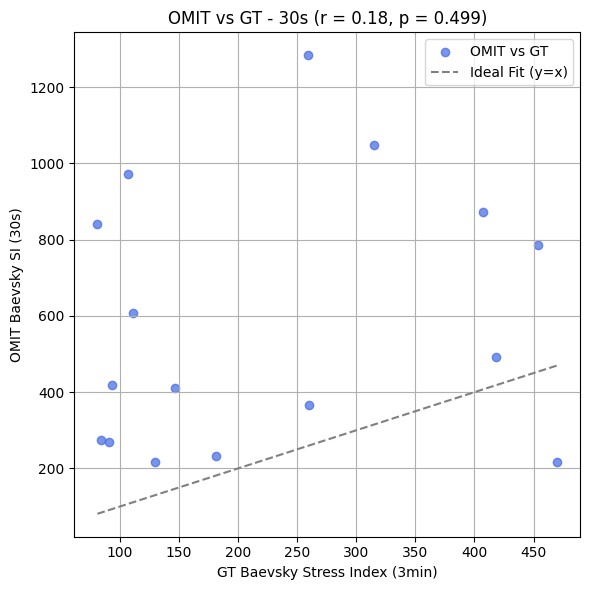

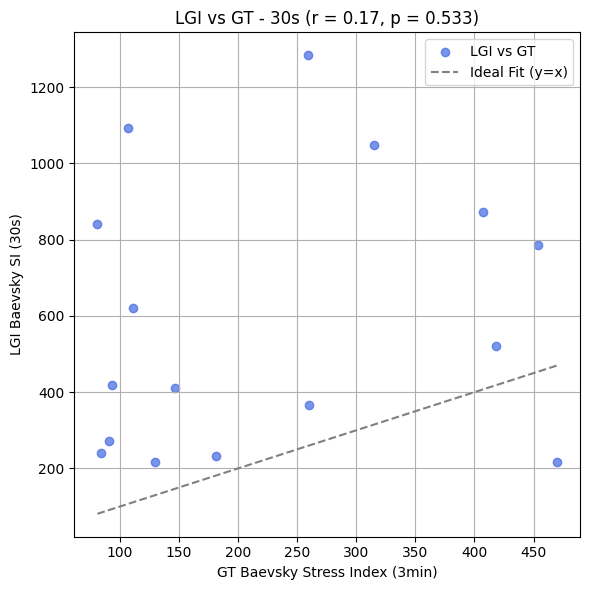

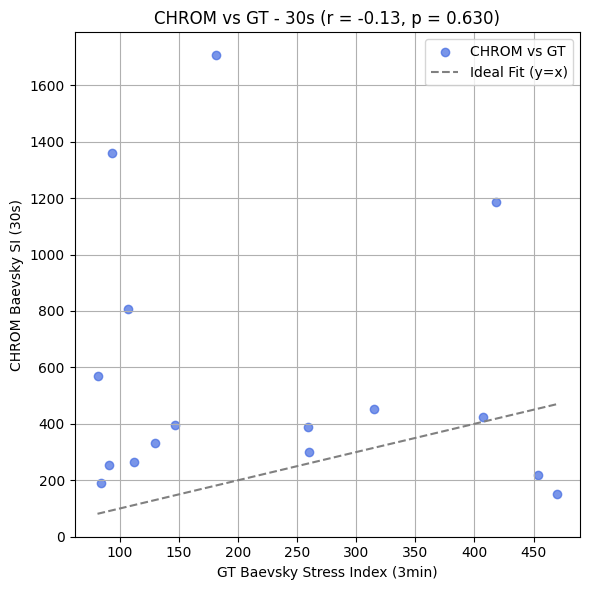

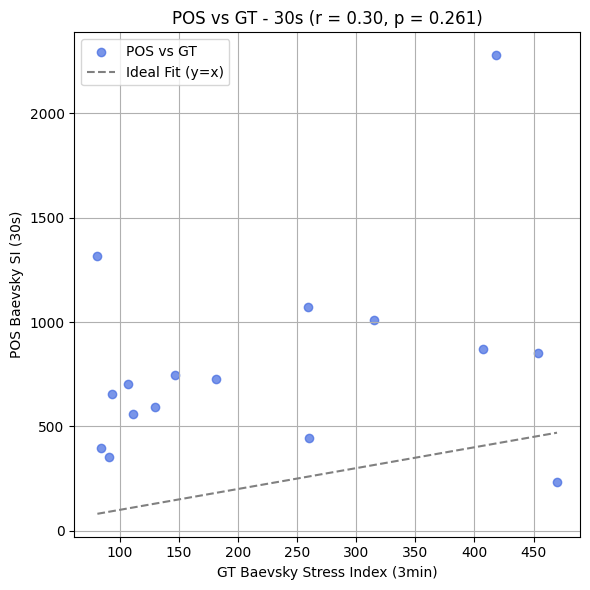

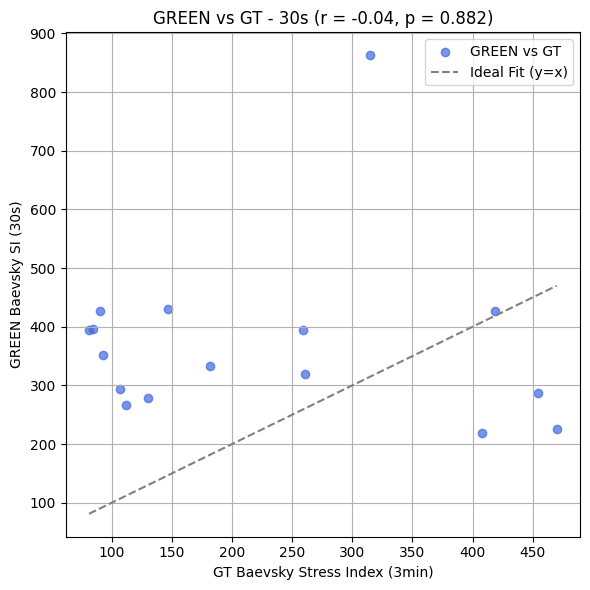

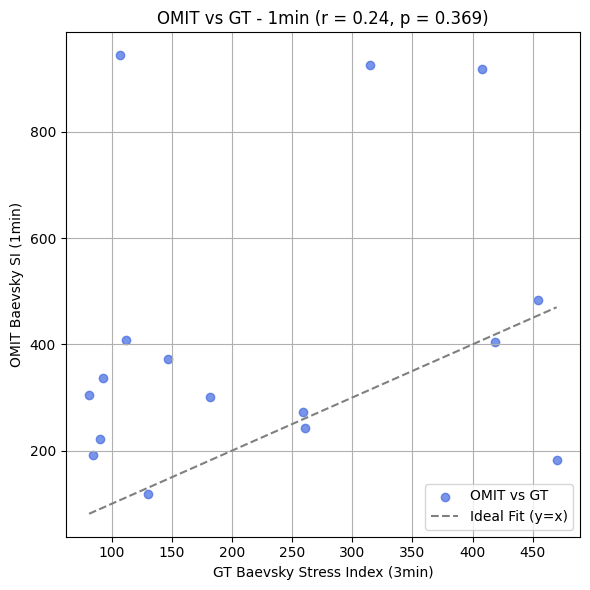

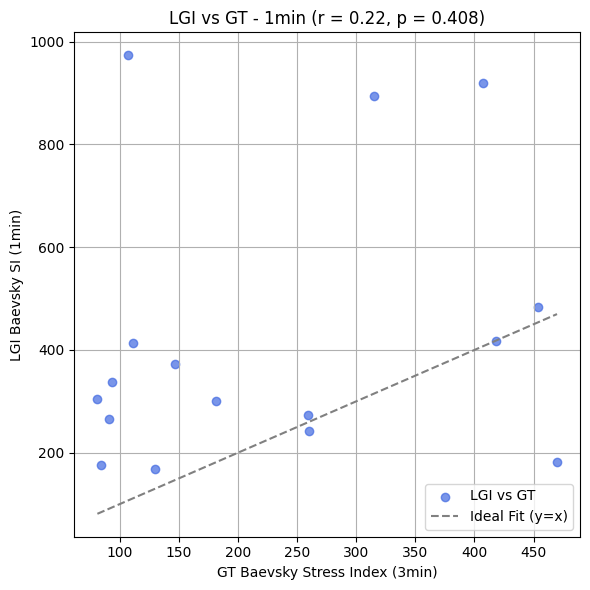

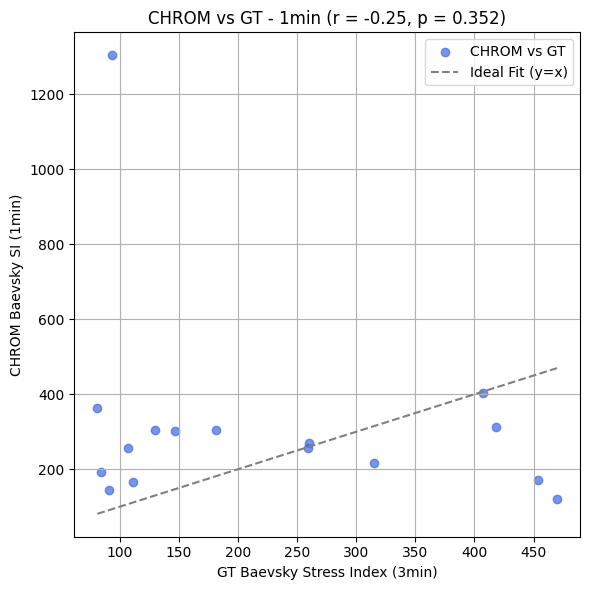

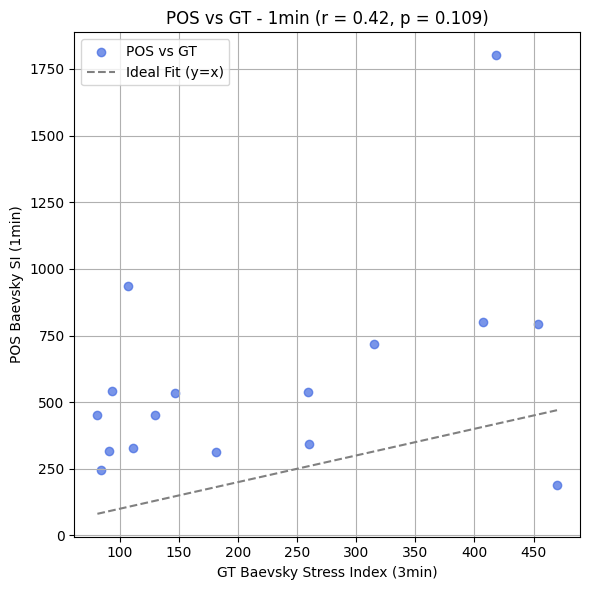

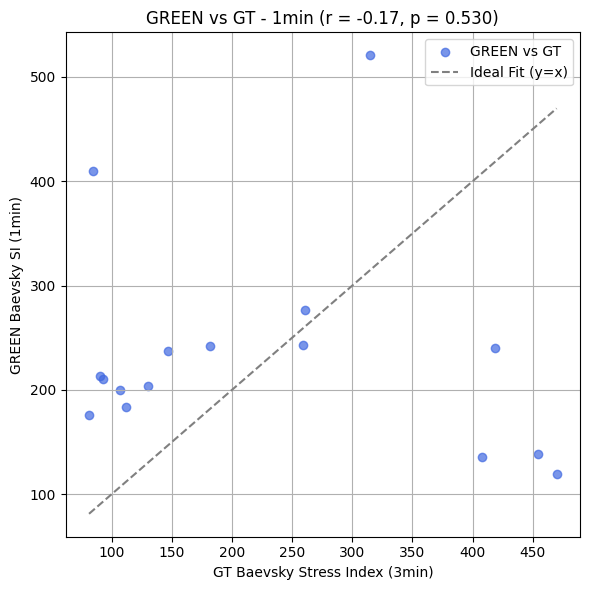

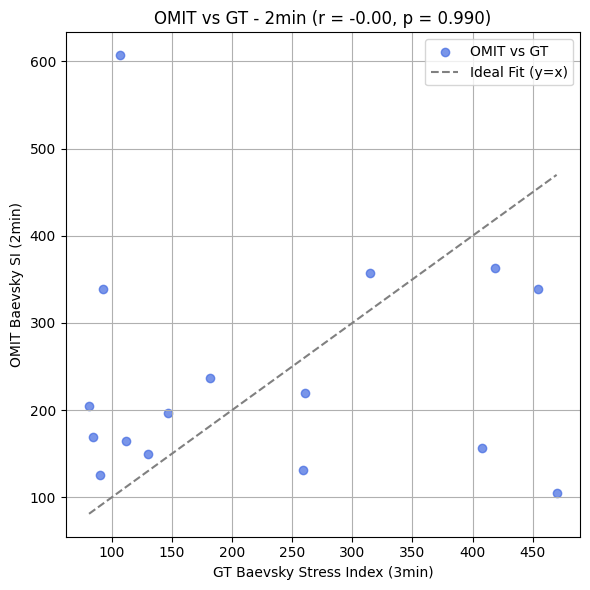

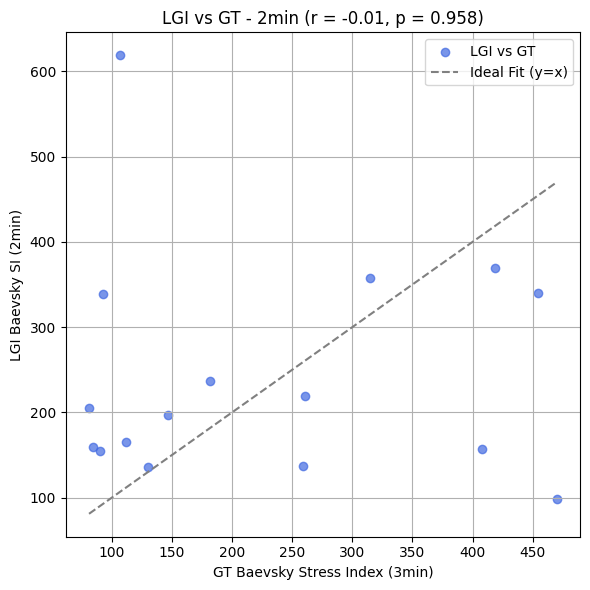

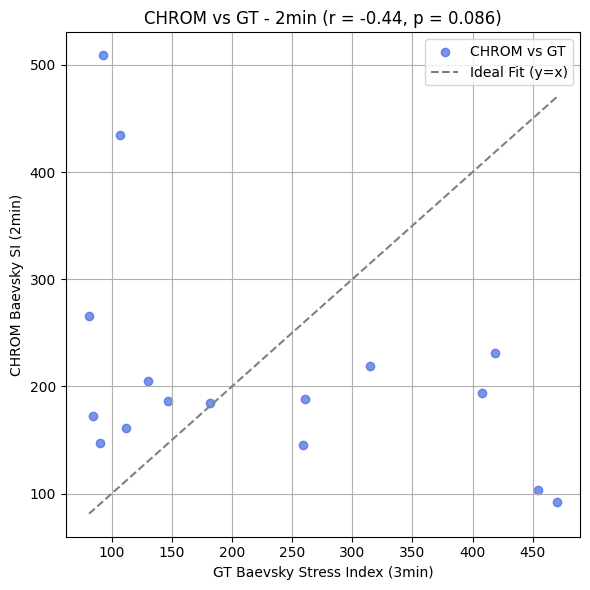

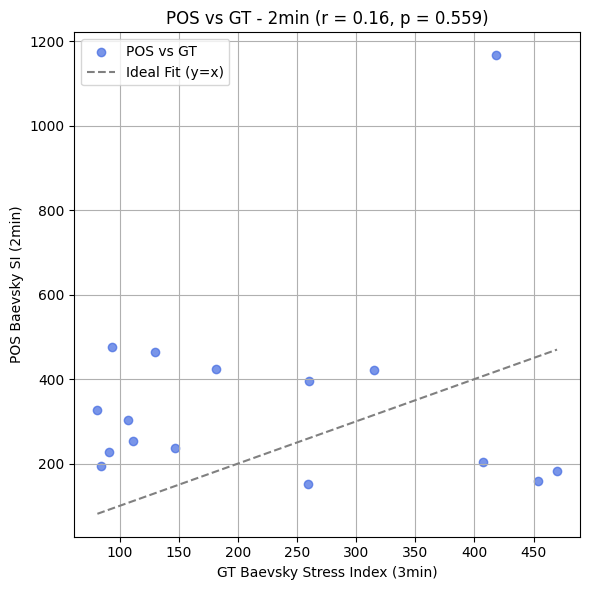

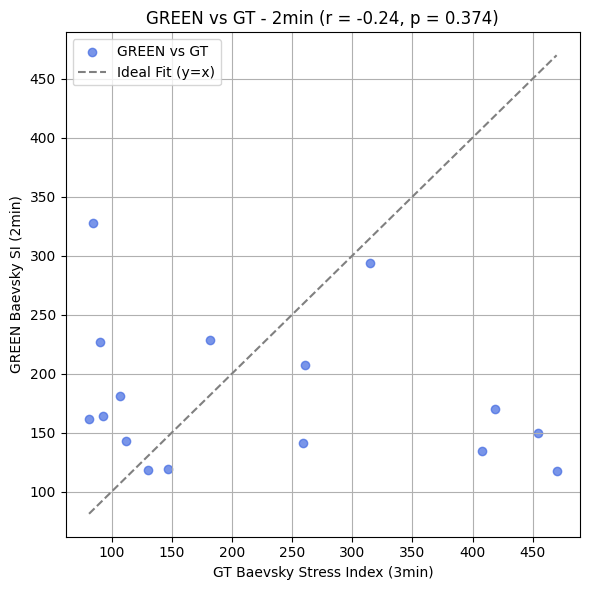

In [10]:
import os
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def process_and_si(signal, sampling_rate):
    cleaned, _, rr = process_rppg_signal(signal, sampling_rate)
    return calculate_baevsky_stress_index_revised(rr)

sampling_rate = 35
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56"]
tasks = ["T1"]

durations = {
    "30s": 30 * sampling_rate,
    "1min": 60 * sampling_rate,
    "2min": 120 * sampling_rate
}

# Data storage for scatter plots
scatter_data = {
    "30s": {"GT": [], "OMIT": [], "LGI": [], "CHROM": [], "POS": [], "GREEN": []},
    "1min": {"GT": [], "OMIT": [], "LGI": [], "CHROM": [], "POS": [], "GREEN": []},
    "2min": {"GT": [], "OMIT": [], "LGI": [], "CHROM": [], "POS": [], "GREEN": []},
}

for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
        continue

    for task in tasks:
        try:
            pos = np.load(os.path.join(root_path, subject, f"{subject}_{task}_POS_rppg.npy"))
            green = np.load(os.path.join(root_path, subject, f"{subject}_{task}_GREEN_rppg.npy"))
            chrom = np.load(os.path.join(root_path, subject, f"{subject}_{task}_CHROM_rppg.npy"))
            lgi = np.load(os.path.join(root_path, subject, f"{subject}_{task}_LGI_rppg.npy"))
            omit = np.load(os.path.join(root_path, subject, f"{subject}_{task}_OMIT_rppg.npy"))
            GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values.flatten()

            gt_si = process_and_si(GT, sampling_rate)

            for label, samples in durations.items():
                try:
                    omit_si = process_and_si(omit[:samples], sampling_rate)
                    lgi_si = process_and_si(lgi[:samples], sampling_rate)
                    chrom_si = process_and_si(chrom[:samples], sampling_rate)
                    pos_si = process_and_si(pos[:samples], sampling_rate)
                    green_si = process_and_si(green[:samples], sampling_rate)

                    scatter_data[label]["GT"].append(gt_si)
                    scatter_data[label]["OMIT"].append(omit_si)
                    scatter_data[label]["LGI"].append(lgi_si)
                    scatter_data[label]["CHROM"].append(chrom_si)
                    scatter_data[label]["POS"].append(pos_si)
                    scatter_data[label]["GREEN"].append(green_si)


                except Exception as inner_e:
                    print(f"  Skipping {subject} {label} due to error: {inner_e}")

        except Exception as e:
            print(f"Error with subject {subject}: {e}")

# Plotting
for label in durations.keys():
    for method in ["OMIT", "LGI", "CHROM", "POS", "GREEN"]:
        gt_vals = scatter_data[label]["GT"]
        rppg_vals = scatter_data[label][method]

        plt.figure(figsize=(6, 6))
        plt.scatter(gt_vals, rppg_vals, label=f"{method} vs GT", alpha=0.7, c="royalblue")
        plt.plot([min(gt_vals), max(gt_vals)], [min(gt_vals), max(gt_vals)], '--', color='gray', label="Ideal Fit (y=x)")

        # Correlation
        if len(gt_vals) >= 2:
            r, p = pearsonr(gt_vals, rppg_vals)
            plt.title(f"{method} vs GT - {label} (r = {r:.2f}, p = {p:.3f})")
        else:
            plt.title(f"{method} vs GT - {label} (Not enough points)")

        plt.xlabel("GT Baevsky Stress Index (3min)")
        plt.ylabel(f"{method} Baevsky SI ({label})")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
